# Gentle Introduction to Pytorch Autograd with Linear Regression
#### By Michael Przystupa


** By the end of this tutorial students will be able to:**:
- Analytically solve a linear regression
- Explain what pytorch automatically handles with it's autograd library
- Construct a linear model using the pytorch module


## Introduction

Linear regression is a fairly common practise and is a good starting place with introducing you building models using the pytorch library. We'll start by showing how analytically you can solve linear regression analytically which we can use to compare how our pytorch model compares. 

First, let's import the libraries we'll need: 


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
#just your typical imports in python 

## The Data Set

We'll be working with a toy dataset which is just a linear function with added guassian noise:
\begin{equation}
 f(x) = ax + b + N(0, 1) 
\end{equation}
In real machine learning, your data won't be so nice, but we want something we can easily look at to get some intuition about how the model works. 

** note ** : In general, we do not KNOW the function our data came from. That's why we want to build models to try and approximate something that looks like our data COULD have come from it.

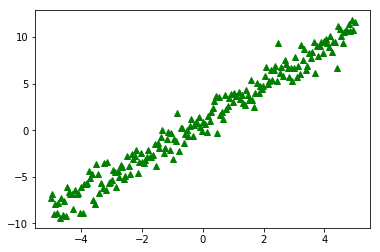

In [13]:
def f( x, a= 2.0, b = 1.0, add_noise=True):
    if add_noise:
        n = np.random.normal(0.0, 1.0)
    else:
            n = 0.0
    return a * x + b + n

X = np.linspace(-5.0, 5.0, num= 200)
y = np.array([f(x) for x in X])

plt.plot(X, y, 'g^')
plt.show()


## Analytically
Clearly, there is some relationship in this data, and we'd like to represent this some how with a function of the form
\begin{equation}
w_{1} x + w_{2} = \hat y
\end{equation}

In machine learning, to find these w's we generally want to have some objective to see how good the weights are. One example is minimizing the mean-squared error which for our equation looks like this:
\begin{equation}
Objective(w) = \sum_{i=1}^{n} (w_{1} x_{i} + w_{2} + - y_{i}) ^{2}
\end{equation}

You'll have to trust me on this, but we can solve this directly by doing the following manipulation:
\begin{equation}
w = (X^{t} X)^{-1} (X^{t} y)
\end{equation}

where X is our data matrix and y is our labels, and w is our weights we want to parameterize

w_0 = [ 1.96972397], w_1 = [ 1.08184388]


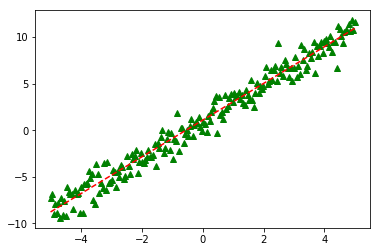

In [14]:
# Solving problem analytically:
X = np.stack((X, np.ones(X.shape[0])), axis=1) #this is so we have w_{2}
y = np.array([y]).transpose() # has to do with shape of data
X_t = X.transpose() 

#Calculating each of the components
X_tX = np.matmul(X_t, X)
X_ty = np.matmul(X_t, y)
w = np.matmul(np.linalg.inv(X_tX) , (X_ty))

#this will show the best weights we can do with the data
print('w_0 = {}, w_1 = {}'.format(w[0], w[1]))

#Plotting our approximations of true values

#lambda is a key word in python for defining smaller functions
lin_model = lambda x : f(x, w[0], w[1], add_noise=False)
y_hat = [lin_model(x) for x in X[:,0]]

plt.plot(X[:,0], y, 'g^')
plt.plot(X[:,0], y_hat, 'r--')
plt.show()


This is all well and good...if you can calculate your inverse. In that case, you're going to have to get creative and do some optimization. 

## Stochastic Gradient Descent  (S.G.D)

This can be fairly math heavy, but here's the gist of what we're going to do:
\begin{equation}
    w = w - \alpha * \nabla Objective(w)
\end{equation}

where $\alpha$ is referred to as the learning rate and is the amount we will update our current weights by at each step and $\nabla Objective(w)$ means we want to take the gradient with respect to our loss. One minor thing with this is that in S.G.D. we are making updates based off single examples in our data and this is done usually for performance reasons (although there is theory about why it works well too). 

Maybe this all seems a little scary, particularly if you're not sure what  a gradient is. Thankfully, pytorch makes it so you don't need to pull out your old calculus textbook and handles calculating these for us as we'll see.

## Pytorch's autograd system

The most useful part of pytorch is the autograd system. The gist of it is that it will automatically calculate gradients for any operations done on a pytorch tensor, so we have to say good bye to our good friend numpy, which is easy to do:

In [15]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Now, to do SGD we'll need a learning rate and an initial set of weights:
alpha = 1e-3
w = torch.randn(2, requires_grad=True) #requires grad is key to do this

To use pytorch's autograd feature, we're going to calculate the prediction with our current weights and call backward on our loss function. When you call .backward() on a tensor of interest, it calculates the gradient and we can access it with the .grad field of tensors to do our update

In [16]:
order = torch.randperm(X.size()[0])

#redefine our linear model to use the tensor version of w
for _ in range(0, 10):
    total_loss = 0.0
    for i in order:
        x = X[i,:]
        y_hat = torch.matmul(x, w) #ax + b esentially
        loss = F.mse_loss(y_hat[0], y[i,0]) #our objective function
        loss.backward() #where our gradients get calculated
        total_loss += loss.item()
        with torch.no_grad():
            w -=  alpha * w.grad
            w.grad.zero_()
    print('Loss on epoch {}:  {}'.format(_, total_loss / X.size()[0]))
    
print(w)


/home/mprzystupa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':


Loss on epoch 0:  15.95085129
Loss on epoch 1:  1.26909185622
Loss on epoch 2:  1.10887930466
Loss on epoch 3:  1.05333386042
Loss on epoch 4:  1.02935324583
Loss on epoch 5:  1.01903245275
Loss on epoch 6:  1.01468058052
Loss on epoch 7:  1.01290969603
Loss on epoch 8:  1.01223487893
Loss on epoch 9:  1.01201125071
tensor([1.9353, 1.0800], requires_grad=True)


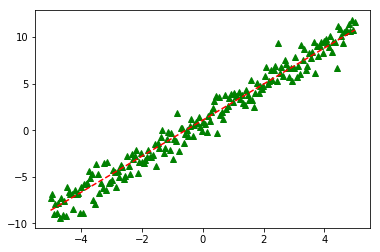

In [17]:

X = X.numpy()
y = y.numpy()
w = w.detach().numpy()
lin_model = lambda x : f(x, w[0], w[1], add_noise=False)
y_hat = [lin_model(x) for x in X[:,0]]

plt.plot(X[:,0], y, 'g^')
plt.plot(X[:,0], y_hat, 'r--')
plt.show()

As we can see, our model now performsabout the same as our analytical solution, but the advantage is that doing it this way is always possible and doesn't rely on our inverse having to exist.

## Going full Pytorch
Now the above loop was to illustrate what pytorch is doing. We cheated a little bit by also using the .backward() call instead of calculating it our selves, but that's the reason WHY these deep learning frameworks are great, because you don't HAVE to do this all by hand. 



Loss on epoch 0:  6.78612589448
Loss on epoch 1:  1.79111157393
Loss on epoch 2:  1.35706431062
Loss on epoch 3:  1.16379238749
Loss on epoch 4:  1.07747364214
Loss on epoch 5:  1.03893169308
Loss on epoch 6:  1.02172259411
Loss on epoch 7:  1.01403922095
Loss on epoch 8:  1.01060867648
Loss on epoch 9:  1.0090773141


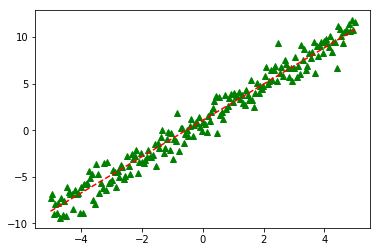

In [18]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()


class LinRegression(nn.Module):
    def __init__(self):
        super(LinRegression, self).__init__()
        self.linear = nn.Linear(2, 1, bias=False )
        #the bias term is generally set to True, but we added the 1's column to x
    
    def forward(self, x):
        return self.linear(x)
    
model = LinRegression()
sgd = optim.SGD(model.parameters(), lr=1e-3)
order = torch.randperm(X.size()[0])
for _ in range(0, 10):
    total_loss = 0.0
    for i in order:
        x = X[i,:]
        y_hat = model(x)
        loss = F.mse_loss(y_hat[0], y[i,0]) #our objective function
        loss.backward() #where our gradients get calculated
        total_loss += loss.item()
        sgd.step()
        sgd.zero_grad()
    print('Loss on epoch {}:  {}'.format(_, total_loss / X.size()[0]))
    
y_hat = model(X)

y_hat = y_hat.detach().numpy()
X = X.numpy()
y = y.numpy()

plt.plot(X[:,0], y, 'g^')
plt.plot(X[:,0], y_hat, 'r--')
plt.show()


## Conclusions

In this tutorial we've seen how to solve linear regression using pytorch's autograd system and how to build models with pytorch. We saw several pytorch packages including torch, torch.optim, torch.nn, and torch.nn.functional. We then saw how to use these modules together to train our model. 


## Exercise: Logistic Regression
Logistic regression is a sort of extension of linear regression for the classification setting. 

Using what you've seen in this tutorial and class, build a logistic regression model to train a model for the following toy dataset:


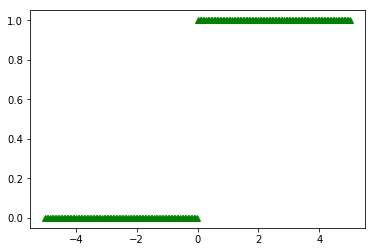

In [19]:
def f(x):
    if x > 0.0:
        return 1.0
    else:
        return 0.0

X = np.linspace(-5.0, 5.0, num= 200)
y = np.array([f(x) for x in X])

plt.plot(X, y, 'g^')
plt.show()

In [ ]:
#starter code:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        #insert code here
    def forward(self, x):
        #insert code 
        return x
    
# some set-up
order = torch.randperm(X.size()[0])
#training loop
for _ in range(0, 10):
    total_loss = 0.0
    for i in order:
        x = X[i]
        y_hat = model(x)
        #insert call to loss function here
        
        loss.backward() #where our gradients get calculated
        total_loss += loss.item()
        sgd.step()
        sgd.zero_grad()
    print('Loss on epoch {}:  {}'.format(_, total_loss / X.size()[0]))
    
y_hat = model(X)
y_hat = y_hat.detach().numpy()
X = X.numpy()
y = y.numpy()

plt.plot(X[:,0], y, 'g^')
plt.plot(X[:,0], y_hat, 'r--')
plt.show()
